In [1]:
import pystan 
import numpy as np
from sklearn.preprocessing import PolynomialFeatures 
import matplotlib.pyplot as plt
from scipy.stats import norm
import arviz # For visualization

In [2]:
# Data-generating function
def f(x):
    return 10*x + 15
    
# Returns a noisy sample from f
def noisyF(x, sigma=0.1):
    return np.random.normal(f(x), sigma)
    
# Samples n_samples independent noisy samples from f where x is selected uniformly at random from interval
def sampleF(n_samples, interval=[0, 6], sigma=0.1):
    x = np.random.uniform(0, 6, n_samples)
    y = noisyF(x, sigma)
    return x, y

# Polynomial basis functions
def phi(x, degree=1):
    poly = PolynomialFeatures(degree=degree)
    return poly.fit_transform(x.reshape(-1,1))

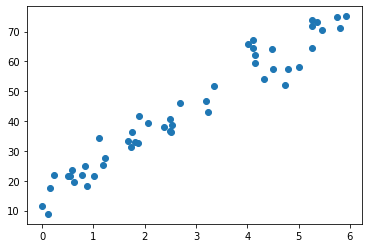

In [3]:
# Generate data
nr_samples = 50
noise_sigma = 5

np.random.seed(1)

(x_train_orig, y_train) = sampleF(nr_samples, sigma=noise_sigma)
(x_test_orig, y_test) = sampleF(nr_samples, sigma=noise_sigma)

poly = PolynomialFeatures(1)
x_train = np.matrix(poly.fit_transform(x_train_orig.reshape(-1, 1)))
x_test = np.matrix(poly.fit_transform(x_test_orig.reshape(-1, 1)))
y_train = np.matrix(y_train).T
y_test = np.matrix(y_test).T

plt.scatter(x_train_orig, y_train.tolist())
plt.show()

## Bayesian Linear regression

Assume that we have observed $n$ pairs $(x_i, y_i)$ where $x_i$ are the feature values and $y_i$ is the label. Let $w\in \mathbb{R}^d$ be our regression weights. The likelihood is 
$$P(y | x, w, \beta) = \prod_{i=1}^{n} N(y_i | w^Tx_i, \beta^{-1}).$$
The parameter $\beta$ has a Gamma prior
$$P(\beta) = Gamma(\beta | a_0, b_0)$$
where $a_0$ and $b_0$ are user-defined hyperparameters. The regression weights have a Gaussian prior
$$P(w) = N(w | \mathbf{0}, \alpha^{-1}\mathbf{I})$$
where $\alpha$ (prior precision) is a user-defined hyperparameter. $$$$

In [4]:
# Specify a standard linear regression model using Stan
lr_std_code = """
data {
    int<lower=0> N;      // Number of observations
    int<lower=0> D;      // Number of dimensions
    vector[N] Y;         // Labels
    matrix[N, D] X;      // Data
    real<lower=0> a0;     // A hyperparameter for noise precision
    real<lower=0> b0;     // A hyperparameter for noise precision
    real<lower=0> alpha; // Prior precision
}
parameters {
    real<lower=0> beta;  // Noise precision
    vector[D] W;         // Weights
}
model {
    for (n in 1:N) {
        Y[n] ~ normal(X[n]*W, sqrt(1/beta)); // Likelihood
    }
    // Priors
    beta ~ gamma(a0, b0);
    W ~ normal(0, sqrt(1/alpha));
}
""" 

# Compile the model
lr_std = pystan.StanModel(model_code = lr_std_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f59604fff802bbf6a0e6059ad4be56c5 NOW.


In [5]:
degree = 1

phi_train = phi(x_train_orig, degree=degree)

n = phi_train.shape[0]
d = phi_train.shape[1]

# Hyperparameters
alpha= 0.1
a0 = 0.01
b0 = 0.01

# Input data for sampler
# A dictionary: the keys and the types of items are described by the "data" block of your model
data_std = {'N': n,
           'D': d,
           'Y': np.array(y_train).reshape(n,),
           'X': phi_train,
           'a0': a0,
           'b0': b0,
           'alpha': alpha}

# Parameters that control the HMC sampler
params = {
    'max_treedepth': 10
}



In [6]:
%%time
fit_std = lr_std.sampling(data=data_std, iter=2000, chains=4, control=params) # Sample from the posterior

CPU times: user 28.8 ms, sys: 36.2 ms, total: 65 ms
Wall time: 361 ms


In [7]:
# Print a summary of inference results
# Includes the mean, standard error, standard deviation, and various percentiles. 
# n_eff can be used to assess mixing, Rhat for assessing convergence
# lp__ is the (unnormalized) log-posterior
print(fit_std)

Inference for Stan model: anon_model_f59604fff802bbf6a0e6059ad4be56c5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta   0.05  2.0e-4 9.5e-3   0.03   0.04   0.05   0.05   0.07   2206    1.0
W[1]  13.36    0.03   1.16  10.89  12.62  13.39  14.14  15.55   1745    1.0
W[2]  10.59  8.4e-3   0.35   9.95  10.36  10.58  10.82  11.31   1737    1.0
lp__ -117.5    0.03   1.27 -120.9 -118.0 -117.1 -116.6 -116.1   1403    1.0

Samples were drawn using NUTS at Tue Apr 28 11:59:31 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


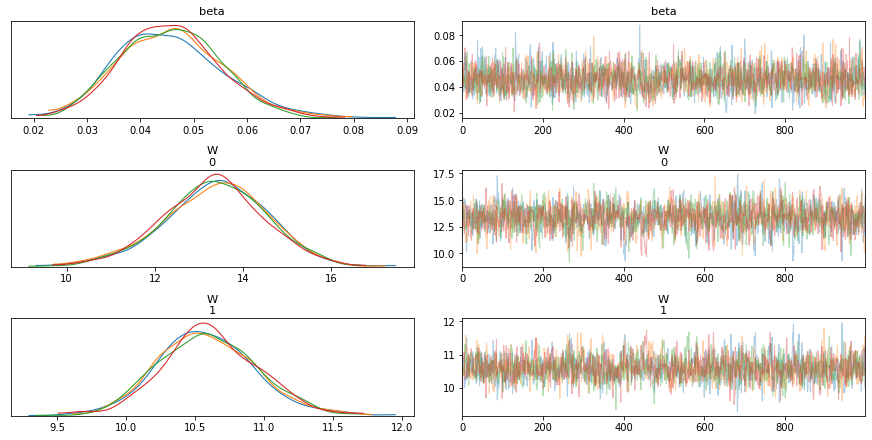

In [8]:
# Plot posterior marginals (left) and traceplots (right) 
arviz.plot_trace(fit_std)
plt.show()

In [9]:
# Extract samples
fit_std.extract()

OrderedDict([('beta',
              array([0.03944699, 0.03846921, 0.0659427 , ..., 0.07024961, 0.03689792,
                     0.03553004])),
             ('W',
              array([[13.86613041, 10.51175718],
                     [14.66334165,  9.91455348],
                     [14.5815565 , 10.53184593],
                     ...,
                     [13.22620459, 10.25032069],
                     [12.27537209, 10.94098877],
                     [13.17184537, 10.60363546]])),
             ('lp__',
              array([-116.55101907, -118.56384957, -118.72503765, ..., -121.51765549,
                     -116.98585633, -116.89985174]))])

In [18]:
def predict(x, w, beta, n_predictions=1):
    n_samples = w_samples.shape[0]
    preds = []
    for i in range(n_predictions):
        ind = np.random.randint(0, n_samples)
        m = np.dot(w[ind, :].reshape(-1, 1).T, x.T)
        sample = norm.rvs(loc=m, scale=np.sqrt(1/beta[ind]))
        preds.append(sample)
    return np.array(preds)

def credibleIntervalSamples(x, w_samples, beta_samples, ci, n_predictions=1000):
    preds =  predict(x, w_samples, beta_samples, n_predictions)

    preds_sorted = np.sort(preds)

    lb_ind = int(np.ceil((1 - ci)/2*n_predictions))
    lb = preds_sorted[lb_ind]
    
    ub_ind = int(np.floor((ci + (1 - ci)/2)*n_predictions))
    ub = preds_sorted[ub_ind]
    
    m = np.mean(preds, axis=0)
    
    return m, lb, ub

def plotCredibleIntervals(x_grid, w_samples, beta_samples, ci=0.95, n_predictions=1000):
    ms = []
    lbs = []
    ubs = []
    for xx in x_grid:
        m, lb, ub = credibleIntervalSamples(phi(np.array([xx]), degree=degree), w_samples, beta_samples, ci, n_predictions=n_predictions)
        ms.append(m)
        lbs.append(lb)
        ubs.append(ub)

    plt.scatter(x_train_orig, y_train.tolist())
    plt.plot(x_grid, ms)
    plt.plot(x_grid, lbs, c='r')
    plt.plot(x_grid, ubs, c='r')
    plt.show()

38
-29.054180776950325

38
-26.932971243382855

38
-24.09081059133539

38
-22.210802180345674

38
-20.011132123302048

38
-17.698463450340817

38
-15.763181910151532

38
-13.448791365088095

38
-11.120963548828726

38
-9.684216911105388

38
-6.538527846112642

38
-5.47998529878288

38
-2.6640667573575234

38
-0.7899414853074127

38
1.423292810963682

38
3.5797980074601643

38
5.727693807573585

38
8.539411632949644

38
10.370598262468798

38
11.464147642934474

38
15.204750411612238

38
16.177236022108914

38
18.648330257345382

38
20.210179628877476

38
23.409061618781877

38
25.102311783729142

38
27.162917027785674

38
28.703570708339075

38
30.95530439042126

38
33.95213795565601

38
35.086792812388666

38
38.104345920939906

38
39.962702711054405

38
42.29357948604788

38
44.00395127611227

38
46.58458742969397

38
48.33349136073109

38
50.856019333803026

38
52.43183559782069

38
55.092215225648815

38
57.039800516914376

38
58.92314359758064

38
61.09674781911421

38
63.28072469

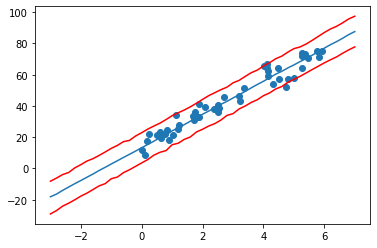

In [19]:
# Plot credible intervals 
ci = 0.95
n_predictions = 1500

w_samples = fit_std.extract()['W']
beta_samples = fit_std.extract()['beta']

x_grid = np.linspace(-3, 7, 51)

plotCredibleIntervals(x_grid, w_samples, beta_samples, ci=ci, n_predictions=n_predictions)

<br>
<br>
<br>

## ARD regression

Assume that we have observed $n$ pairs $(x_i, y_i)$ where $x_i$ are the feature values and $y_i$ is the label. Let $w\in \mathbb{R}^d$ be our regression weights. The likelihood is 
$$P(y | x, w, \beta) = \prod_{i=1}^{n} N(y_i | w^Tx_i, \beta^{-1}).$$

For the noise precision $\beta$, we use a Gamma prior
$$ P(\beta) = Gamma(\beta | a_0, b_0) $$
where $a_0$ and $b_0$ are user-defined hyperparameters. 

The prior for the weights $w$ is a Gaussian distribution 
$$ P(w | \alpha_1, \ldots \alpha_d) = \prod_{j=1}^{d} N(w_j | 0, \alpha_j^{-1}). $$
Notice that the difference compared to the standard case is that instead of having one precision parameter $\alpha$ that is same for all dimensions, we have a separate prior precision $\alpha_j$ for each dimension. Furthermore, $\alpha_j$ is not assumed to be known but we place a prior on it. The prior for $\alpha_j$ is a Gamma distribution
$$ P(\alpha_j) =  Gamma(\alpha_j | c_0, d_0)\quad \forall j=1,\ldots, d$$
where $c_0$ and $d_0$ are user-defined hyperparameters.  

In [12]:
lr_ard_code = """
data {
    int<lower=0> N;   // Number of observations
    int<lower=0> D;   // Number of dimensions
    matrix[N,D] X;    // Data
    vector[N] Y;      // Labels
    real<lower=0> a0; // A hyperparameter for noise precision
    real<lower=0> b0; // A hyperparameter for noise precision
    real<lower=0> c0; // A hyperparameter for prior precision (ARD)
    real<lower=0> d0; // A hyperparameter for prior precision (ARD)
    }    
parameters {
    vector[D] W;
    vector<lower=0>[D] alpha; // Prior precisions
    real<lower=0> beta; // Noise precision
    }
transformed parameters {
    vector<lower=0>[D] t_alpha; // Prior variances
    real<lower=0> t_beta; // Noise variance
    for (d in 1:D) {
        t_alpha[d] = 1/sqrt(alpha[d]);
        }
    t_beta =  1/sqrt(beta);
    }
model {
    beta ~ gamma(a0, b0);
    alpha ~ gamma(c0, d0);
    W ~ normal(0,  t_alpha);
    Y ~ normal(X*W, t_beta);
    }"""

In [13]:
lr_ard = pystan.StanModel(model_code = lr_ard_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af803f2ab0a48e82561aed5a07bdac4c NOW.


In [14]:
degree = 1

phi_train = phi(x_train_orig, degree=degree)

n = phi_train.shape[0]
d = phi_train.shape[1]

# Hyperparameters
a0 = 0.01
b0 = 0.01
c0 = 0.01
d0 = 0.01

# Input data for sampler
# A dictionary: the keys and the types of items are described by the "data" block of your model
data_ard = {'N': n,
           'D': d,
           'Y': np.array(y_train).reshape(n,),
           'X': phi_train,
           'a0': a0,
           'b0': b0,
           'c0': c0,
           'd0': d0}

# Parameters that control the HMC sampler
params = {
    'max_treedepth': 10
}

In [15]:
%%time
fit_ard = lr_ard.sampling(data=data_ard, iter=2000, chains=4, control=params) # Sample from the posterior

CPU times: user 87.6 ms, sys: 52.4 ms, total: 140 ms
Wall time: 558 ms


In [16]:
print(fit_ard)

Inference for Stan model: anon_model_af803f2ab0a48e82561aed5a07bdac4c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
W[1]        14.94    0.03   1.22  12.51  14.12  14.95  15.75   17.3   2108    1.0
W[2]        10.24  8.0e-3   0.36   9.54   9.99  10.24  10.48  10.96   2069    1.0
alpha[1]   4.6e-3  1.1e-4 6.8e-3 2.3e-6 4.6e-4 2.0e-3 6.0e-3   0.02   3700    1.0
alpha[2]   9.8e-3  2.2e-4   0.01 1.0e-5 9.2e-4 4.4e-3   0.01   0.05   4090    1.0
beta         0.05  1.8e-4 9.8e-3   0.03   0.04   0.05   0.05   0.07   3081    1.0
t_alpha[1] 519.55  357.94  1.1e4   6.56  12.91  22.35  46.69 661.43    964    1.0
t_alpha[2] 105.08   34.41 1687.8    4.4   8.76  15.11  32.92 314.27   2406    1.0
t_beta       4.69  8.8e-3   0.49   3.83   4.34   4.65   4.99   5.77   3099    1.0
lp__       -109.5    0.06   1.85 -114.1 -110.5 -109.1 -108.1 -107.1   104

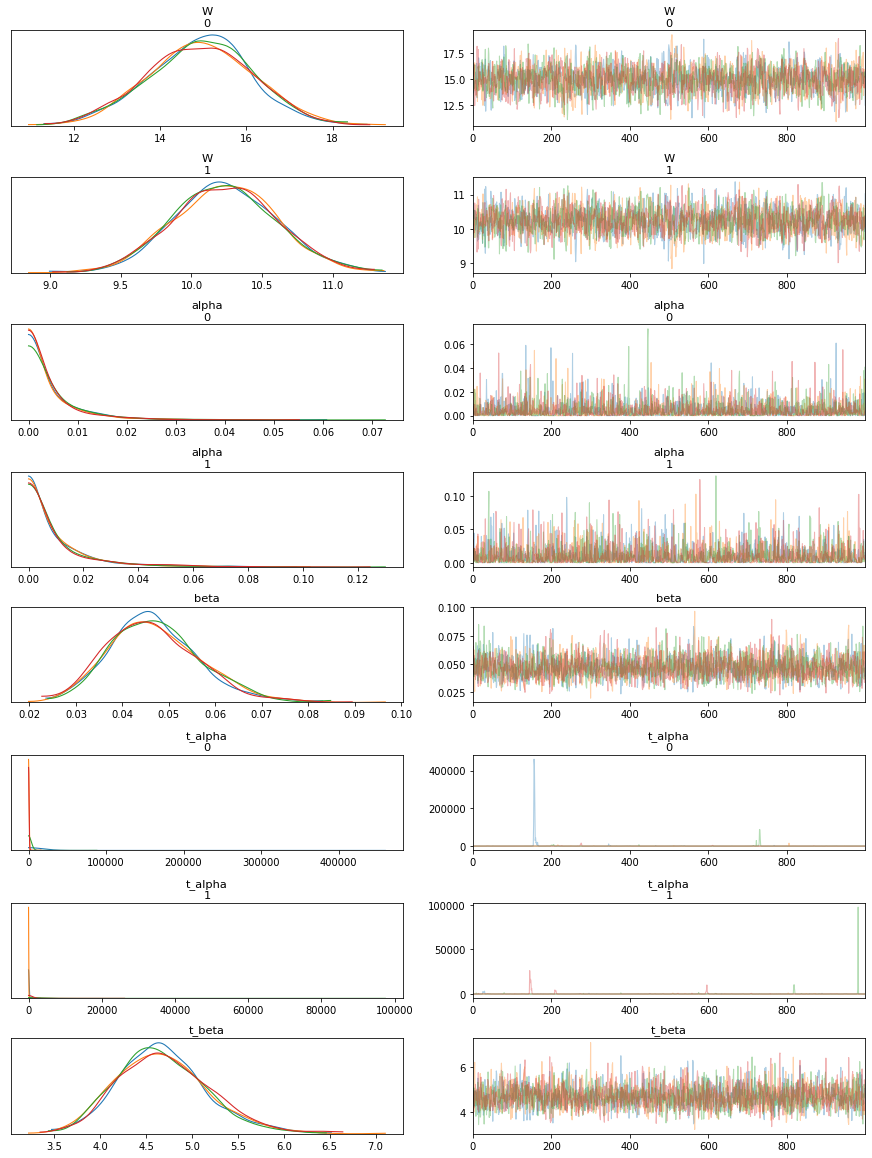

In [17]:
# Plot posterior marginals (left) and traceplots (right) 
arviz.plot_trace(fit_ard)
plt.show()

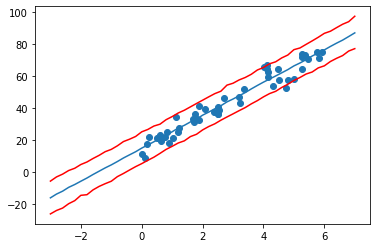

In [18]:
# Plot credible intervals 
ci = 0.95
n_predictions = 1000

w_samples = fit_ard.extract()['W']
beta_samples = fit_ard.extract()['beta']

x_grid = np.linspace(-3, 7, 51)

plotCredibleIntervals(x_grid, w_samples, beta_samples, ci=ci, n_predictions=n_predictions)